# Learning from the past 
## ARIMA models with exogenous variables

In this notebook, I will try to forecast the three targets using ARIMA models. ARIMA is a traditional time-series forecasting model that learns by looking for **autocorrelations** in the data, meaning it looks at past data to predict the future. In this case, we would look at previous values of Carbon Monoxide, Benzene and Nitrous Oxides to try to predict their future values. 
ARIMA models can sometimes be improved by adding exogenous variables to the mix, so features that are external to the original target time-series. In this case, the exogenous variables are the sensors, the temperature, the humidity and other features we manage to engineer.

**Note:** some of the sections are works in progress, I'll be adding to them in the next few days! Be sure to give any feedback, I'd appreciate it!

### Section 1: Loading required packages and reading the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import statsmodels

import plotly
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Paths
path_train = '/kaggle/input/tabular-playground-series-jul-2021/train.csv'
path_test = '/kaggle/input/tabular-playground-series-jul-2021/test.csv'
path_sub = '/kaggle/input/tabular-playground-series-jul-2021/sample_submission.csv'

# Seed for reproducibility
SEED = 100

In [ ]:
# Reading the original training and testing sets
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

# Saving the indexes to separate variables for future reference
train_index = pd.to_datetime(train['date_time'])
test_index = pd.to_datetime(test['date_time'])

# First data check
print(f'Train shape: {train.shape}')
train.head()

In [ ]:
print(f'Test shape: {test.shape}')
test.head()

### Section 2: Exploratory Data Analysis (EDA) 
We start with a high-level feature exploration, then we dig deeper into the targets. 

In [ ]:
# Let's start with a brief description of the data
train.describe()

**Takeaways:**
* No missing values (woo!).
* The features are on very different scale. Sensors have similar range but deg_C and humidities don't.
* As we're going to use some traditional forecasting models, we will do some plots to understand the data better and tune our models accordingly.

In [ ]:
train['date_time'] = pd.to_datetime(train['date_time'])
print(f'Training set goes from {train["date_time"].min()} to {train["date_time"].max()} - for a total of {train["date_time"].max() - train["date_time"].min()}.\n')

test['date_time'] = pd.to_datetime(test['date_time'])
print(f'Test set goes from {test["date_time"].min()} to {test["date_time"].max()} - for a total of {test["date_time"].max() - test["date_time"].min()}.')

Looks like we have less than a year of data. Let's plot some graphs.

Thanks to @melanie7744 for the plots: https://www.kaggle.com/melanie7744/tps7-interactive-eda-with-plotly

In [ ]:
fig = go.Figure()

fig.add_trace(
      go.Scatter(x=train.date_time, 
                 y=train.target_carbon_monoxide, 
                 mode = 'lines', 
                 line = {'color':'darkgoldenrod', 'width' : 1},
                 name="Carbon Monoxide")
)

fig.update_layout(
    title="Carbon Monoxide over time"
)
fig.show()

Data ranges from ~March 2010 to ~January 2011.

**Carbon Monoxide**
* In general, looks stationary, but we could apply a certain degree of differentiation.
* Some people have found what looks like bad data (outliers, bad reads) that could impact model performance.
* We will do a first analysis with all the data.

In [ ]:
fig = go.Figure()

fig.add_trace(
      go.Scatter(x=train.date_time, 
                 y=train.target_benzene, 
                 mode = 'lines', 
                 line = {'color':'darkgoldenrod', 'width' : 1},
                 name="Benzene")
)

fig.update_layout(
    title="Benzene over time"
)
fig.show()

**Benzene**

There are some clear cases of readings marking 0, April 9, June 19, August 25, December 14 (hover over the data points to find these dates). These are the examples of what could be bad data.

In [ ]:
fig = go.Figure()

fig.add_trace(
      go.Scatter(x=train.date_time, 
                 y=train.target_nitrogen_oxides, 
                 mode = 'lines', 
                 line = {'color':'darkgoldenrod', 'width' : 1},
                 name="Nitrogen_oxides")
)

fig.update_layout(
    title="Nitrogen Oxides over time"
)
fig.show()

**Nitrogen Oxides** 

Nitrogen Oxide readings have a big change after september 2010, the range becomes a lot wider, with max values hitting 1400, where before the max values were around ~600. This could cause us some problems because we have a split of different behaviors, so we don't really know what's "normal". Could be a case of seasonality but we can't really confirm it without a few more years of data.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation plots to understand significance between lags
plot_acf(train.target_carbon_monoxide, title="ACF - Carbon Monoxide", lags=96)
plt.show()

plot_acf(train.target_benzene, title="ACF - Benzene", lags=96)
plt.show()

plot_acf(train.target_nitrogen_oxides, title="ACF - Nitrogen Oxides", lags=96)
plt.show()

**Autocorrelation Plots (ACF)**

In simple words, an **autocorrelation** in a time-series is the relationship between a data point in some time and another data point in the past. For example, if we have daily data, and we know our present observation is correlated with yesterday's observation, then we know that yesterday can be used to explained today! 

So we're trying to understand the relationship between one observation and observations in the past as a function of the lag between them.

In this case, our observations are hourly, so one time lag would be a difference of one hour.

Let's look at the plots above:

**Carbon Monoxide**

As we can see, the y axis marks the correlation value (0 to 1) and the x-axis marks the time lags. We can understand from this graph that the past few lags are heavily correlated with our current observation. So the past few hours are correlated with the current hour. Also, every ~24 lags we get a high correlation with the current observation, which means emissions are cyclical, the time of day does have an influence. 

However, look how the peaks get smaller every 24 hours. That means that every day that goes by, the current observations are less and less correlated with the past observations. 

Finally, take a look at the small shaded area above and below the x-axis, this tells us which of the lags have a *statistically significant correlation* with our current observation. The lags that are outside the range are statistically significant (according to our confidence interval). In this case all lags before ~30 hours seem significant, however we will try to verify this in the next step.

**Benzene and Nitrogen Oxides**

Benzene has a very similar behavior to Carbon Monoxide, while Nitrogen Oxides shows higher correlations overall, with the same trend we observed in the first two plots. It seems a lot of the time-lags are significant, this could, however, be a TRAP! Let's introduce PACF plots.



In [ ]:
# PACF plots 
from statsmodels.graphics.tsaplots import plot_pacf

# Autocorrelation plots to understand significance between lags
plot_pacf(train.target_carbon_monoxide, title="PACF - Carbon Monoxide", lags=48)
plt.show()

plot_pacf(train.target_benzene, title="PACF - Benzene", lags=48)
plt.show()

plot_pacf(train.target_nitrogen_oxides, title="PACF - Nitrogen Oxides", lags=48)
plt.show()

**Partial Autocorrelation plots (PACF)**

PACF plots are a great complement to ACF plots, they're one for the other! 

PACF plots explain the *partial correlations* between the lags. A partial correlation tells us the amount of correlation between two variables that is NOT explained by their mutual correlations with other variables. In this case, the other variables are the lower-order lags. So the partial correlation tells us the amount of correlation between our current observation and a time lag, that is NOT explained by lower-order time-lags. 

Take a look at the ACF and the PACF for Carbon Monoxide. In the ACF pretty much every higher order correlation was significant up until the 30th lag. The PACF tells us a different part of the story, it looks like from lag 4-~18, the higher order lags are explained by the lower order ones. So in reality lags 1-3 are the most important here, autocorrelations for the higher order lags (4-18) were propagated by the lower order lags (1-3). 

It also looks like we have a similar story for Benzene and Nitrogen Oxides).

These highly positive low-order correlations tell us how a good model could look like, but I'll go into further detail later.

Note: take into account the ACF and PACF should be used after differencing the series, in this case we're assuming the data is already stationary. If it had a clear trend or seasonality, you should differentiate before doing any autocorrelation analysis.

### Feature engineering 

* This a class that can be used to add new features.
* New features are: 
* day_of_week:  (monday, tuesday, etc.)
* is_weekend: boolean value, True if day_of_week is saturday or sunday
* time_of_day: hour
* is_daylight: boolean, True if time_of_day between 6 and 19
* is_dark: boolean, True if time_of_day between 18 and 7

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# class to add engineered features, will be used as part of a pipeline for rapid testing
class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, add_day_of_week=True, add_is_weekend=True,add_time_of_day=True, add_is_daylight=False, add_is_dark=True):
        self.add_day_of_week = add_day_of_week
        self.add_is_weekend = add_is_weekend
        self.add_time_of_day = add_time_of_day
        self.add_is_daylight = add_is_daylight
        self.add_is_dark = add_is_dark 
        
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        
        X['date_time'] = pd.to_datetime(X['date_time'])
        X['day_of_week'] = X['date_time'].dt.dayofweek
        X['time_of_day'] = X['date_time'].dt.hour

        if self.add_is_weekend:
            X.loc[(X['day_of_week'] == 5)|(X['day_of_week'] == 6), 'is_weekend'] = 1
        if self.add_is_daylight:
            X.loc[(X['time_of_day']>6) & (X['time_of_day']<19), 'is_daylight'] = 1
        if self.add_is_dark:
            X.loc[(X['time_of_day']>18) | (X['time_of_day']<7), 'is_dark'] = 1
        
        X.fillna(0, inplace=True)
        
        if not self.add_day_of_week:
            X.drop(columns='day_of_week', inplace=True)
        if not self.add_time_of_day:
            X.drop(columns='time_of_day', inplace=True)
            
        X.set_index('date_time', inplace=True)
                    
        return X

In [ ]:
%pip install pmdarima

In [ ]:
# Modeling helper functions
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Helper functions
def plot_real_vs_preds(y_test_:pd.DataFrame, preds:np.ndarray, target):
    df_preds = pd.DataFrame(preds, index=y_test_.index)
    plt.figure(figsize=(17,5))
    plt.plot(y_test_.index, y_test_, 'b-', label='Test')
    plt.plot(y_test_.index, df_preds.values, 'g--', label='Predictions')
    plt.legend()
    plt.grid()
    plt.title(f'Real data vs. predictions - {target}')
    plt.show()
    
def calc_rmsle(real, preds, print_result=False):
    # try:
    rmsle = np.sqrt(mean_squared_log_error(real, preds))
    if print_result:
        print(f'RMSLE: {rmsle}')
    else:
        return rmsle
          
    #except ValueError:
    #    print(f'Negative values in predictions, error cannot be calculated.')
    
def time_cross_validation(splits, train:pd.DataFrame, target:pd.DataFrame, model_):
    
    time_kfold = TimeSeriesSplit(n_splits=splits)

    # Loop over the splits
    for idx_fold, (train_ix, val_ix )in enumerate(time_kfold.split(train)):

        # Folds, training and validation sets
        X_train, X_val = train.iloc[train_ix], train.iloc[val_ix]
        y_train, y_val = target.iloc[train_ix], target.iloc[val_ix]

        model_ = model_.fit(y_train, X_train)
        preds = model_.predict(n_periods=val_ix.shape[0], exogenous=X_val)
        
        try:
            rmsle = calc_rmsle(y_val, preds)
            print(f'Fold {idx_fold} -> RMSLE: {rmsle}')
            
        except ValueError:
            print(f'Fold {idx_fold} -> Negative values in predictions, error cannot be calculated.')
            
def fit_predict_auto_arima(y_train, X_train, X_test):

    model = auto_arima(y=y_train, X=X_train, stepwise=True)
    # model = SARIMAX(y_train, X_train, (3,1,2))
    print(model.summary())
    return model, model.predict(n_periods=X_test.shape[0], exogenous=X_test)

def fit_predict_sarima_model(X_test, model):

    # model = auto_arima(y=y_train, X=X_train, stepwise=True)
    fitted_model = model.fit()
    print(type(fitted_model))
    print(fitted_model.summary())
    return fitted_model, fitted_model.predict(end=X_test.shape[0] - 1, exogenous=X_test)

### Section 3: Modeling



**ARIMA architecture**

ARIMA stands for AutoRegressive Integrated Moving Average, it has three components: autocorrelation (AR), moving average(MA) and differentiation. I'll brief each of the components:

Autocorrelation (AR) = basically modeling a variable against itself, using past observations to model new observations.
Moving Average (MA) = instead of using past observations of the variable, moving averages use past forecast errors.
Differencing = it's the degree of differencing applied to a time-series to make it stationary. A stationary time-series is one in which any of its fragments has equal properties. For example: time-series with trends or seasonality are not stationary. Before using ARIMA, you must ensure your time-series is stationary, this can sometimes be solved by differentiating the series.

ARIMA also has a notation we should be aware about: ARIMA (p,d,q). The three letters represent the orders of the autocorrelation, differencing and moving average parts respectively. For example, an ARIMA(1,0,0) model is strictly an autocorrelation model.

The orders must be integers. In simple words, the order represents the degree to which we apply each component, for example: if we had ARIMA (5,0,0), we would be adding 5 terms to the autocorrelation equation, meaning we would be considering 5 time lags.
In the case of differencing, the order determines the rounds of differencing applied.

Remember the ACF-PACF plots? We saw the 3-5 lags had high correlation with our current observation. In general,a positive correlation in lag-1 in the PACF tells us we could benefit from adding terms to the AR part of the model, so ARIMA (n,0,0).

On the other hand, negative correlations in lag-1 means we could benefit from adding MA terms to the model. 

This rules only tell us the baseline, we would benefit from experimenting by adding or subtracting terms.


#### Section 3.1: Carbon Monoxide Model

In [ ]:
feat_creator = FeatureCreator()
# train.reset_index(inplace=True)
# train = feat_creator.transform(train)

In [ ]:
# First training, let's get a model using the auto_arima function to start testing
df_train = train.drop(columns=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])
df_train.set_index('date_time', inplace=True)
df_target_cox = train[['target_carbon_monoxide']]
df_target_cox.set_index(train_index, inplace=True)

In [ ]:
# Split for validation, no cross validation yet as we're getting a starter model
X_train, X_test, y_train_cox, y_test_cox = train_test_split(df_train, df_target_cox, test_size=0.2,
                                                            random_state=SEED, shuffle=False)

The auto_arima function finds a good fit to the data using several statistical tests, it's a good way to start probing models.

Reference: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html


In [ ]:
%%time
# the auto_arima function finds a good fit to the data using several statistical tests, it's a good way to start probing models
# best_model_cox, preds_cox = fit_predict_auto_arima(y_train_cox, X_train, X_test)

In [ ]:
best_model_cox = SARIMAX(y_train_cox, X_train, (3,1,2), freq='H')
fitted_model_cox, preds_cox = fit_predict_sarima_model(X_test, best_model_cox)

Take a look at the model summary. SARIMAX is the model architecture, the S means it's a Seasonal ARIMA model, but in this case we didn't add any seasonal terms, so it's the architecture we saw before. The X means we added exogenous features to the model (temperature, sensors, humidity).

Now, we saw a cut-off in the autocorrelation significance at about 4 lags, so it makes sense that the best model found has 3 orders of autocorrelation.  

Let's plot the predictions against the real values to get an estimate of performance.

In [ ]:
plot_real_vs_preds(y_test_cox, preds_cox, 'Carbon Monoxide')

As you can probably see from the plot, there are some big differences when the real emissions are really low. This could be random noise, which would be good for the model, but it's possible that's not the case.

Let's go ahead and calculate the RMSLE.

In [ ]:
print('Carbon Monoxide')
rmsle_cox = calc_rmsle(y_test_cox, preds_cox, print_result=True)

THE RMSLE is not that good compared to other models, however, we haven't applied any feature engineering, and we haven't tuned the model.

Other models for reference:
CatBoost with feature engineering by Tsai Yi Lin: https://www.kaggle.com/andy6804tw/catboost-13feature-cross-validation

XGBoost: https://www.kaggle.com/mehrankazeminia/1-tps-jul-21-xgboost-leaveonegroupout

#### Time-Series Cross Validation
Now let's do some Cross Validation to get an idea of how our model would perform.

Because we're using a time-series approach to forecasting, we can't use traditional Cross Validation methods, because they usually rely on shuffling the training set to get the different folds. In this case, we need to maintain the order of the observations, because we can't forecast the past with the future! 

Here's an image that explains the CV approach I will use, it's called Time Series Cross Validation:

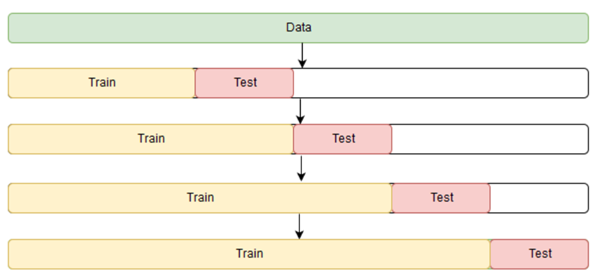

Source: https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4 

That way, we always ensure we're training on past data and evaluating on future data, which makes sense for autocorrelation models and forecasting in general.

In [ ]:
%%time
from pmdarima.arima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error

splits = 3
print('Carbon Monoxide\n')
# time_cross_validation(splits, df_train, df_target_cox, best_model_cox)

Interestingly enough, some predictions are negative for the first folds, which means we can't calculate the RMSLE (the competition metric).

#### Section 3.2: Benzene Model

In [ ]:
df_target_ben = train[['target_benzene']]
df_target_ben.set_index(train_index, inplace=True)

# Split for validation, no cross validation yet as we're getting a starter model
X_train, X_test, y_train_ben, y_test_ben = train_test_split(df_train, df_target_ben, test_size=0.2,
                                                            random_state=SEED, shuffle=False)

In [ ]:
%%time
# the auto_arima function finds a good fit to the data using several statistical tests, it's a good way to start probing models
# best_model_ben, preds_ben = fit_predict_auto_arima(y_train_ben, X_train, X_test)

In [ ]:
best_model_ben = SARIMAX(y_train_ben, X_train, (2,1,2))
fitted_model_ben, preds_ben = fit_predict_sarima_model(X_test, best_model_ben)

In [ ]:
plot_real_vs_preds(y_test_ben, preds_ben, 'Benzene')

In [ ]:
print('Benzene')
# rmsle_ben = calc_rmsle(y_test_ben, preds_ben, print_result=True)

In [ ]:
%%time
splits = 3
print('Benzene\n')
# time_cross_validation(splits, df_train, df_target_ben, best_model_ben)

#### Section 3.3: Nitrogen Oxides Model

In [ ]:
df_target_nox = train[['target_nitrogen_oxides']]
df_target_nox.set_index(train_index, inplace=True)

# Split for validation, no cross validation yet as we're getting a starter model
X_train, X_test, y_train_nox, y_test_nox = train_test_split(df_train, df_target_nox, test_size=0.2,
                                                            random_state=SEED, shuffle=False)

In [ ]:
%%time
# the auto_arima function finds a good fit to the data using several statistical tests, it's a good way to start probing models
# best_model_nox, preds_nox = fit_predict_auto_arima(y_train_nox, X_train, X_test)

In [ ]:
best_model_nox = SARIMAX(y_train_nox, X_train, (1,1,1))
fitted_model_nox, preds_nox = fit_predict_sarima_model(X_test, best_model_nox)

In [ ]:
plot_real_vs_preds(y_test_nox, preds_nox, 'Nitrogen Oxides')

In [ ]:
print('Nitrogen Oxides')
# rmsle_nox = calc_rmsle(y_test_nox, preds_nox, print_result=True)

In [ ]:
%%time
splits = 3
print('Nitrogen Oxides\n')
# time_cross_validation(splits, df_train, df_target_nox, best_model_nox)

### Section 4: Model tuning and Feature Engineering

--- Work in progress ---

### Section 5: Submission

Finally, the submission for the competition. These models aren't competitive as is, but we could apply some feature engineering to boost performance, also maybe some model tuning couldn't hurt. Those are the next steps!

In [ ]:
test.set_index('date_time', inplace=True)
preds_cox = fitted_model_cox.predict(end=test.shape[0]-1, exogenous=test)
preds_ben = fitted_model_ben.predict(end=test.shape[0]-1, exogenous=test)
preds_nox = fitted_model_nox.predict(end=test.shape[0]-1, exogenous=test)

sub = pd.DataFrame(np.c_[preds_cox, preds_ben, preds_nox], index=test_index).reset_index()
sub.columns = ['date_time', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
sub.to_csv('submission.csv', index=False)

### References and future reading:

Chapter 8 on ARIMA Models of Rob Hyndman's and George Athanasopoulos' excellent book on forecasting called Forecasting (Principles and practice): https://otexts.com/fpp2/arima.html

A gentle introduction to autocorrelation and partial autocorrelation by Jason Brownlee: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

